# Algorithm: Random Forest Regressor
--------------------------------------
Random Forest là thuật toán Ensemble Learning dựa trên nhiều cây quyết định:
- Kỹ thuật Bagging: Huấn luyện nhiều cây trên các tập con khác nhau của dữ liệu
- Voting: Kết quả cuối cùng là trung bình của tất cả các cây
- Ưu điểm:
  * Giảm overfitting tốt hơn Decision Tree đơn lẻ
  * Robust với outliers và noise
  * Không cần chuẩn hóa dữ liệu
  * Cung cấp Feature Importance tự nhiên

# Import library

In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

print("All libraries imported successfully")

All libraries imported successfully


# Load dữ liệu

In [3]:
# Đọc dữ liệu
df = pd.read_csv('../data/hcm_weather_processed.csv')

print(f"Kích thước dữ liệu: {df.shape}")
print(f"Các cột: {df.keys().tolist()}")

Kích thước dữ liệu: (87720, 32)
Các cột: ['time', 'temperature_2m', 'dew_point_2m', 'apparent_temperature', 'relative_humidity_2m', 'precipitation', 'wind_speed_10m', 'wind_gusts_10m', 'wind_direction_10m', 'surface_pressure', 'cloud_cover', 'cloud_cover_low', 'cloud_cover_mid', 'cloud_cover_high', 'shortwave_radiation', 'weather_code', 'vapour_pressure_deficit', 'zone', 'lat', 'lon', 'hour', 'day_of_week', 'month', 'day_of_year', 'year', 'season', 'is_weekend', 'time_of_day', 'is_rainy', 'temp_feel_diff', 'humidity_level', 'wind_level']


In [5]:
# Cấu hình hiển thị
pd.set_option('display.max_columns', None)
plt.style.use('seaborn-v0_8-whitegrid')

# Cấu hình mốc thời gian 
VAL_CUTOFF = '2025-03-01'   # Từ đây đến Test là Validation (Đề thi thử)
TEST_CUTOFF = '2025-06-01'  # Từ đây về sau là Test (Đề thi thật)

ZONES = ['HCM_Center', 'HCM_East', 'HCM_NorthWest', 'HCM_South', 'HCM_Coastal']
HORIZONS = [1, 6, 12, 24]

print("Đã cấu hình tham số")

Đã cấu hình tham số


# HÀM TIỀN XỬ LÝ (FEATURE ENGINEERING)

In [6]:
def preprocess_features(df_input):
    data = df_input.copy()
    data['time'] = pd.to_datetime(data['time'])
    data = data.sort_values('time')
    
    # 1. Xử lý One-Hot Encoding
    if 'weather_code' in data.columns:
        data['weather_code'] = data['weather_code'].astype(str)
    
    categorical_cols = ['season', 'day_of_week', 'weather_code']
    valid_cats = [c for c in categorical_cols if c in data.columns]
    data = pd.get_dummies(data, columns=valid_cats, drop_first=True)
    
    # 2. Time Cyclical Features
    data['hour_sin'] = np.sin(2 * np.pi * data['hour'] / 24)
    data['hour_cos'] = np.cos(2 * np.pi * data['hour'] / 24)
    data['month_sin'] = np.sin(2 * np.pi * data['month'] / 12)
    data['month_cos'] = np.cos(2 * np.pi * data['month'] / 12)
    
    # 3. Wind Direction Cyclical
    if 'wind_direction_10m' in data.columns:
        data['wind_sin'] = np.sin(2 * np.pi * data['wind_direction_10m'] / 360)
        data['wind_cos'] = np.cos(2 * np.pi * data['wind_direction_10m'] / 360)
    
    # 4. LAG FEATURES (Quan trọng nhất cho Time Series)
    lag_cols = [
        'temperature_2m',           # Quan trọng nhất
        'relative_humidity_2m',     # Giữ nhiệt
        'precipitation',            # Mưa làm giảm nhiệt
    ]
    
    lag_hours = [1, 3, 6, 12, 24, 36, 48]
    
    for col in lag_cols:
        if col in data.columns:
            for i in lag_hours:
                data[f'{col}_lag_{i}'] = data[col].shift(i)
    
    # === LẤY DANH SÁCH FEATURES ===
    lag_features = [c for c in data.columns if '_lag_' in c]
    
    cyclical_features = [
        'hour_sin', 'hour_cos',
        'month_sin', 'month_cos',
        'wind_sin', 'wind_cos'
    ]
    
    categorical_features = [
        c for c in data.columns
        if c.startswith('season_')
        or c.startswith('day_of_week_')
        or c.startswith('weather_code_')
    ]
    
    meta_features = ['temperature_2m', 'time', 'zone']
    
    # GỘP TẤT CẢ
    cols_to_keep = (
        lag_features
        + cyclical_features
        + categorical_features
        + meta_features
    )
    
    return data[cols_to_keep]

print("Đã định nghĩa hàm preprocess_features()")

Đã định nghĩa hàm preprocess_features()


#  FINE-TUNING (TÌM THAM SỐ TỐI ƯU)

In [7]:
print(">>> BẮT ĐẦU FINE-TUNING (Thử nghiệm trên HCM_East, T+24h)...")

# 1. Chuẩn bị dữ liệu
tuning_zone = 'HCM_East'
tuning_horizon = 24

# Lọc vùng & Tiền xử lý
df_tune = df[df['zone'] == tuning_zone].copy()
df_tune = preprocess_features(df_tune)

# Tạo Target
df_tune['target'] = df_tune['temperature_2m'].shift(-tuning_horizon)
df_tune = df_tune.dropna()

# 2. Chia Train/Val
tune_train = df_tune[(df_tune['time'] < VAL_CUTOFF)]
tune_val = df_tune[(df_tune['time'] >= VAL_CUTOFF) & (df_tune['time'] < TEST_CUTOFF)]

# Xóa các cột không cần thiết
cols_to_drop = ['time', 'zone', 'temperature_2m', 'target']

X_tune_train = tune_train.drop(columns=cols_to_drop, errors='ignore')
y_tune_train = tune_train['target']

X_tune_val = tune_val.drop(columns=cols_to_drop, errors='ignore')
y_tune_val = tune_val['target']

print(f"-> Số lượng Features đưa vào model: {X_tune_train.shape[1]}")

# 3. Lưới tham số cho Random Forest
param_grid = [
    {'n_estimators': 100, 'max_depth': 10, 'min_samples_split': 5},
    {'n_estimators': 100, 'max_depth': 15, 'min_samples_split': 5},
    {'n_estimators': 150, 'max_depth': 15, 'min_samples_split': 10},
    {'n_estimators': 200, 'max_depth': 20, 'min_samples_split': 10}
]

best_score = float('inf')
best_params = {}

# 4. Chạy Grid Search
for params in param_grid:
    model = RandomForestRegressor(
        n_estimators=params['n_estimators'],
        max_depth=params['max_depth'],
        min_samples_split=params['min_samples_split'],
        random_state=42,
        n_jobs=-1
    )
    
    model.fit(X_tune_train, y_tune_train)
    preds = model.predict(X_tune_val)
    rmse = np.sqrt(mean_squared_error(y_tune_val, preds))
    
    print(f"Params: {params} => Val RMSE: {rmse:.4f}")
    
    if rmse < best_score:
        best_score = rmse
        best_params = params

print(f"\n>>> THAM SỐ TỐI ƯU ĐƯỢC CHỌN: {best_params}")


>>> BẮT ĐẦU FINE-TUNING (Thử nghiệm trên HCM_East, T+24h)...
-> Số lượng Features đưa vào model: 43
Params: {'n_estimators': 100, 'max_depth': 10, 'min_samples_split': 5} => Val RMSE: 1.2103
Params: {'n_estimators': 100, 'max_depth': 15, 'min_samples_split': 5} => Val RMSE: 1.2069
Params: {'n_estimators': 150, 'max_depth': 15, 'min_samples_split': 10} => Val RMSE: 1.2037
Params: {'n_estimators': 200, 'max_depth': 20, 'min_samples_split': 10} => Val RMSE: 1.1999

>>> THAM SỐ TỐI ƯU ĐƯỢC CHỌN: {'n_estimators': 200, 'max_depth': 20, 'min_samples_split': 10}


# HUẤN LUYỆN CHÍNH (FINAL TRAINING)

In [14]:
final_results = []
models = {}
test_data = {}

# Lấy tham số tối ưu
FINAL_N_ESTIMATORS = best_params.get('n_estimators', 150)
FINAL_MAX_DEPTH = best_params.get('max_depth', 15)
FINAL_MIN_SAMPLES_SPLIT = best_params.get('min_samples_split', 10)

print(f"\n>>> BẮT ĐẦU HUẤN LUYỆN 5 VÙNG x 4 MỐC THỜI GIAN...")
print(f"Tham số: n_estimators={FINAL_N_ESTIMATORS}, max_depth={FINAL_MAX_DEPTH}, "
      f"min_samples_split={FINAL_MIN_SAMPLES_SPLIT}")

for zone in ZONES:
    print(f"\n--- Xử lý vùng: {zone} ---")
    
    # 1. Lọc vùng & Tiền xử lý
    zone_df = df[df['zone'] == zone].copy()
    processed_base = preprocess_features(zone_df)
    
    # Chạy lần lượt các mốc dự báo
    for h in HORIZONS:
        # 2. Tạo Target (Shift ngược h giờ)
        data_h = processed_base.copy()
        data_h['target'] = data_h['temperature_2m'].shift(-h)
        data_h = data_h.dropna()
        
        # 3. Chia Train/Val/Test (Theo trục thời gian)
        data_train_val = data_h[data_h['time'] < TEST_CUTOFF]
        test = data_h[data_h['time'] >= TEST_CUTOFF]
        train = data_train_val[data_train_val['time'] < VAL_CUTOFF]
        val = data_train_val[data_train_val['time'] >= VAL_CUTOFF]
        
        # Lọc dữ liệu đầu vào
        cols_to_drop = ['time', 'zone', 'target', 'temperature_2m']
        
        # 4. Tách X, y
        X_train = train.drop(columns=cols_to_drop, errors='ignore')
        y_train = train['target']
        
        X_val = val.drop(columns=cols_to_drop, errors='ignore')
        y_val = val['target']
        
        X_test = test.drop(columns=cols_to_drop, errors='ignore')
        y_test = test['target']
        
        # 5. Huấn luyện Model
        model = RandomForestRegressor(
            n_estimators=FINAL_N_ESTIMATORS,
            max_depth=FINAL_MAX_DEPTH,
            min_samples_split=FINAL_MIN_SAMPLES_SPLIT,
            random_state=42,
            n_jobs=-1
        )
        
        model.fit(X_train, y_train)
        
        # 6. Đánh giá
        preds = model.predict(X_test)
        rmse = np.sqrt(mean_squared_error(y_test, preds))
        mae = mean_absolute_error(y_test, preds)
        r2 = r2_score(y_test, preds)
        
        # Lưu kết quả
        final_results.append({
            'Zone': zone,
            'Horizon': h,
            'Model': 'Random Forest',
            'RMSE': rmse,
            'MAE': mae,
            'R2': r2
        })
        
        # Chỉ lưu dữ liệu vẽ biểu đồ cho mốc 24h
        if h == 24:
            models[zone] = model
            test_data[zone] = {'y_test': y_test, 'preds': preds, 'rmse': rmse}
            
            # ===== HUẤN LUYỆN ARIMA CHO SO SÁNH (CHỈ MỐC 24H) =====
            print(f"  → Huấn luyện ARIMA cho so sánh...")
            
            # Chuẩn bị time series
            ts_full = zone_df[['temperature_2m', 'time']].copy()
            ts_full = ts_full.sort_values('time')
            ts_full = ts_full.set_index('time')
            ts_full = ts_full.asfreq('h')
            
            # Split giống như ML
            n = len(ts_full)
            train_size = int(0.7 * n)
            val_size = int(0.15 * n)
            
            # ARIMA: Combine train + val làm training
            train_ts = ts_full[:train_size + val_size]
            test_ts = ts_full[train_size + val_size:]
            
            # Auto-find best order (grid search đơn giản)
            best_aic = np.inf
            best_order = None
            
            for p in range(0, 3):
                for d in range(0, 2):
                    for q in range(0, 3):
                        try:
                            arima_model = ARIMA(train_ts, order=(p, d, q))
                            fitted = arima_model.fit(method_kwargs={"warn_convergence": False})
                            if fitted.aic < best_aic:
                                best_aic = fitted.aic
                                best_order = (p, d, q)
                        except:
                            continue
            
            if best_order is not None:
                try:
                    # Fit final model
                    final_arima = ARIMA(train_ts, order=best_order)
                    fitted_final = final_arima.fit(method_kwargs={"warn_convergence": False})
                    
                    # Forecast test set
                    arima_forecast = fitted_final.forecast(steps=len(test_ts))
                    
                    # Align với y_test
                    min_len = min(len(arima_forecast), len(y_test))
                    arima_forecast = arima_forecast[:min_len]
                    y_test_arima = y_test.iloc[:min_len]
                    
                    # Đánh giá ARIMA
                    arima_rmse = np.sqrt(mean_squared_error(y_test_arima, arima_forecast))
                    arima_mae = mean_absolute_error(y_test_arima, arima_forecast)
                    arima_r2 = r2_score(y_test_arima, arima_forecast)
                    
                    final_results.append({
                        'Zone': zone,
                        'Horizon': h,
                        'Model': f'ARIMA{best_order}',
                        'RMSE': arima_rmse,
                        'MAE': arima_mae,
                        'R2': arima_r2
                    })
                    
                    print(f"  → ARIMA{best_order} RMSE: {arima_rmse:.4f}°C, R²: {arima_r2:.4f}")
                    
                except Exception as e:
                    print(f"  ARIMA training failed: {str(e)}")
            else:
                print(f"  Could not find suitable ARIMA order")

print("\nHoàn thành huấn luyện!")


>>> BẮT ĐẦU HUẤN LUYỆN 5 VÙNG x 4 MỐC THỜI GIAN...
Tham số: n_estimators=200, max_depth=20, min_samples_split=10

--- Xử lý vùng: HCM_Center ---
  → Huấn luyện ARIMA cho so sánh...
  Could not find suitable ARIMA order

--- Xử lý vùng: HCM_East ---
  → Huấn luyện ARIMA cho so sánh...
  Could not find suitable ARIMA order

--- Xử lý vùng: HCM_NorthWest ---
  → Huấn luyện ARIMA cho so sánh...
  Could not find suitable ARIMA order

--- Xử lý vùng: HCM_South ---
  → Huấn luyện ARIMA cho so sánh...
  Could not find suitable ARIMA order

--- Xử lý vùng: HCM_Coastal ---
  → Huấn luyện ARIMA cho so sánh...
  Could not find suitable ARIMA order

Hoàn thành huấn luyện!


# BÁO CÁO KẾT QUẢ

In [15]:
results_df = pd.DataFrame(final_results)

# 1. Kết quả tổng thể
print("\n" + "="*80)
print("=== KẾT QUẢ TỔNG THỂ ===")
print("="*80)
print(results_df.to_string(index=False))

# 2. So sánh giữa các model
print("\n" + "="*80)
print("=== SO SÁNH THEO MODEL ===")
print("="*80)
model_avg = results_df.groupby('Model')[['RMSE', 'MAE', 'R2']].mean()
print(model_avg.sort_values('RMSE').to_string())

# 3. Random Forest theo từng vùng
print("\n" + "="*80)
print("=== RANDOM FOREST THEO VÙNG (MỐC 24H) ===")
print("="*80)
rf_24h = results_df[(results_df['Model'] == 'Random Forest') & 
                     (results_df['Horizon'] == 24)].sort_values('RMSE')
print(rf_24h.to_string(index=False))

best_zone = rf_24h.iloc[0]
worst_zone = rf_24h.iloc[-1]

print(f"\nDễ dự báo nhất: {best_zone['Zone']}")
print(f"  RMSE: {best_zone['RMSE']:.4f}°C, R²: {best_zone['R2']:.4f}")

print(f"\nKhó dự báo nhất: {worst_zone['Zone']}")
print(f"  RMSE: {worst_zone['RMSE']:.4f}°C, R²: {worst_zone['R2']:.4f}")

# 4. ARIMA theo từng vùng (mốc 24h)
print("\n" + "="*80)
print("=== ARIMA THEO VÙNG (MỐC 24H) ===")
print("="*80)
arima_24h = results_df[(results_df['Model'].str.contains('ARIMA')) & 
                        (results_df['Horizon'] == 24)].sort_values('RMSE')
if len(arima_24h) > 0:
    print(arima_24h.to_string(index=False))
else:
    print("Không có kết quả ARIMA")

# 5. Pivot table
print("\n" + "="*80)
print("=== BẢNG TỔNG HỢP RMSE (RANDOM FOREST) ===")
print("="*80)
rf_only = results_df[results_df['Model'] == 'Random Forest']
pivot_table = rf_only.pivot(index='Zone', columns='Horizon', values='RMSE')
print(pivot_table.to_string())

print("\n" + "="*80)
print("=== BẢNG TỔNG HỢP MAE (RANDOM FOREST) ===")
print("="*80)
pivot_mae = rf_only.pivot(index='Zone', columns='Horizon', values='MAE')
print(pivot_mae.to_string())



=== KẾT QUẢ TỔNG THỂ ===
         Zone  Horizon         Model     RMSE      MAE       R2
   HCM_Center        1 Random Forest 0.859423 0.562143 0.864553
   HCM_Center        6 Random Forest 1.121747 0.821915 0.769444
   HCM_Center       12 Random Forest 1.151615 0.840010 0.756926
   HCM_Center       24 Random Forest 1.149467 0.844360 0.756957
     HCM_East        1 Random Forest 0.843579 0.553107 0.862266
     HCM_East        6 Random Forest 1.083003 0.790398 0.773192
     HCM_East       12 Random Forest 1.128540 0.825454 0.753697
     HCM_East       24 Random Forest 1.145632 0.842872 0.745135
HCM_NorthWest        1 Random Forest 0.868000 0.565730 0.881102
HCM_NorthWest        6 Random Forest 1.106090 0.808597 0.807058
HCM_NorthWest       12 Random Forest 1.133503 0.824562 0.797319
HCM_NorthWest       24 Random Forest 1.149475 0.839423 0.790750
    HCM_South        1 Random Forest 0.849025 0.566760 0.864692
    HCM_South        6 Random Forest 1.110468 0.821755 0.768726
    HCM_South 

# TRỰC QUAN HÓA

##  HEATMAP

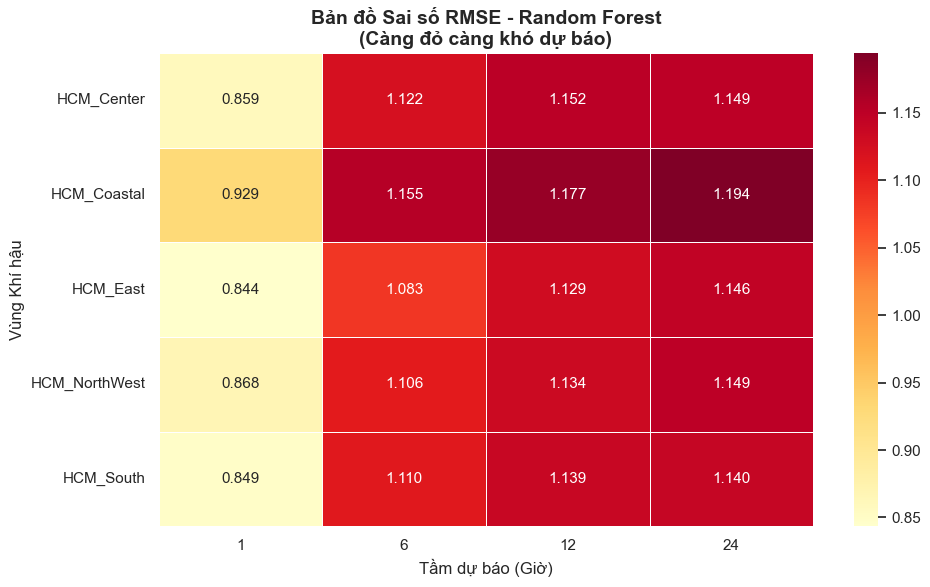

In [19]:
# HEATMAP: RMSE Random Forest theo VÙNG & GIỜ
plt.figure(figsize=(10, 6))

rf_only = results_df[results_df['Model'] == 'Random Forest']
pivot_rmse = rf_only.pivot(index='Zone', columns='Horizon', values='RMSE')
pivot_rmse = pivot_rmse[[1, 6, 12, 24]]  # Sắp xếp cột theo thứ tự

sns.heatmap(pivot_rmse, annot=True, fmt=".3f", cmap="YlOrRd", linewidths=.5)
plt.title('Bản đồ Sai số RMSE - Random Forest\n(Càng đỏ càng khó dự báo)', 
          fontsize=14, fontweight='bold')
plt.ylabel('Vùng Khí hậu')
plt.xlabel('Tầm dự báo (Giờ)')
plt.tight_layout()
plt.show()

## BIỂU ĐỒ ĐƯỜNG (24H)

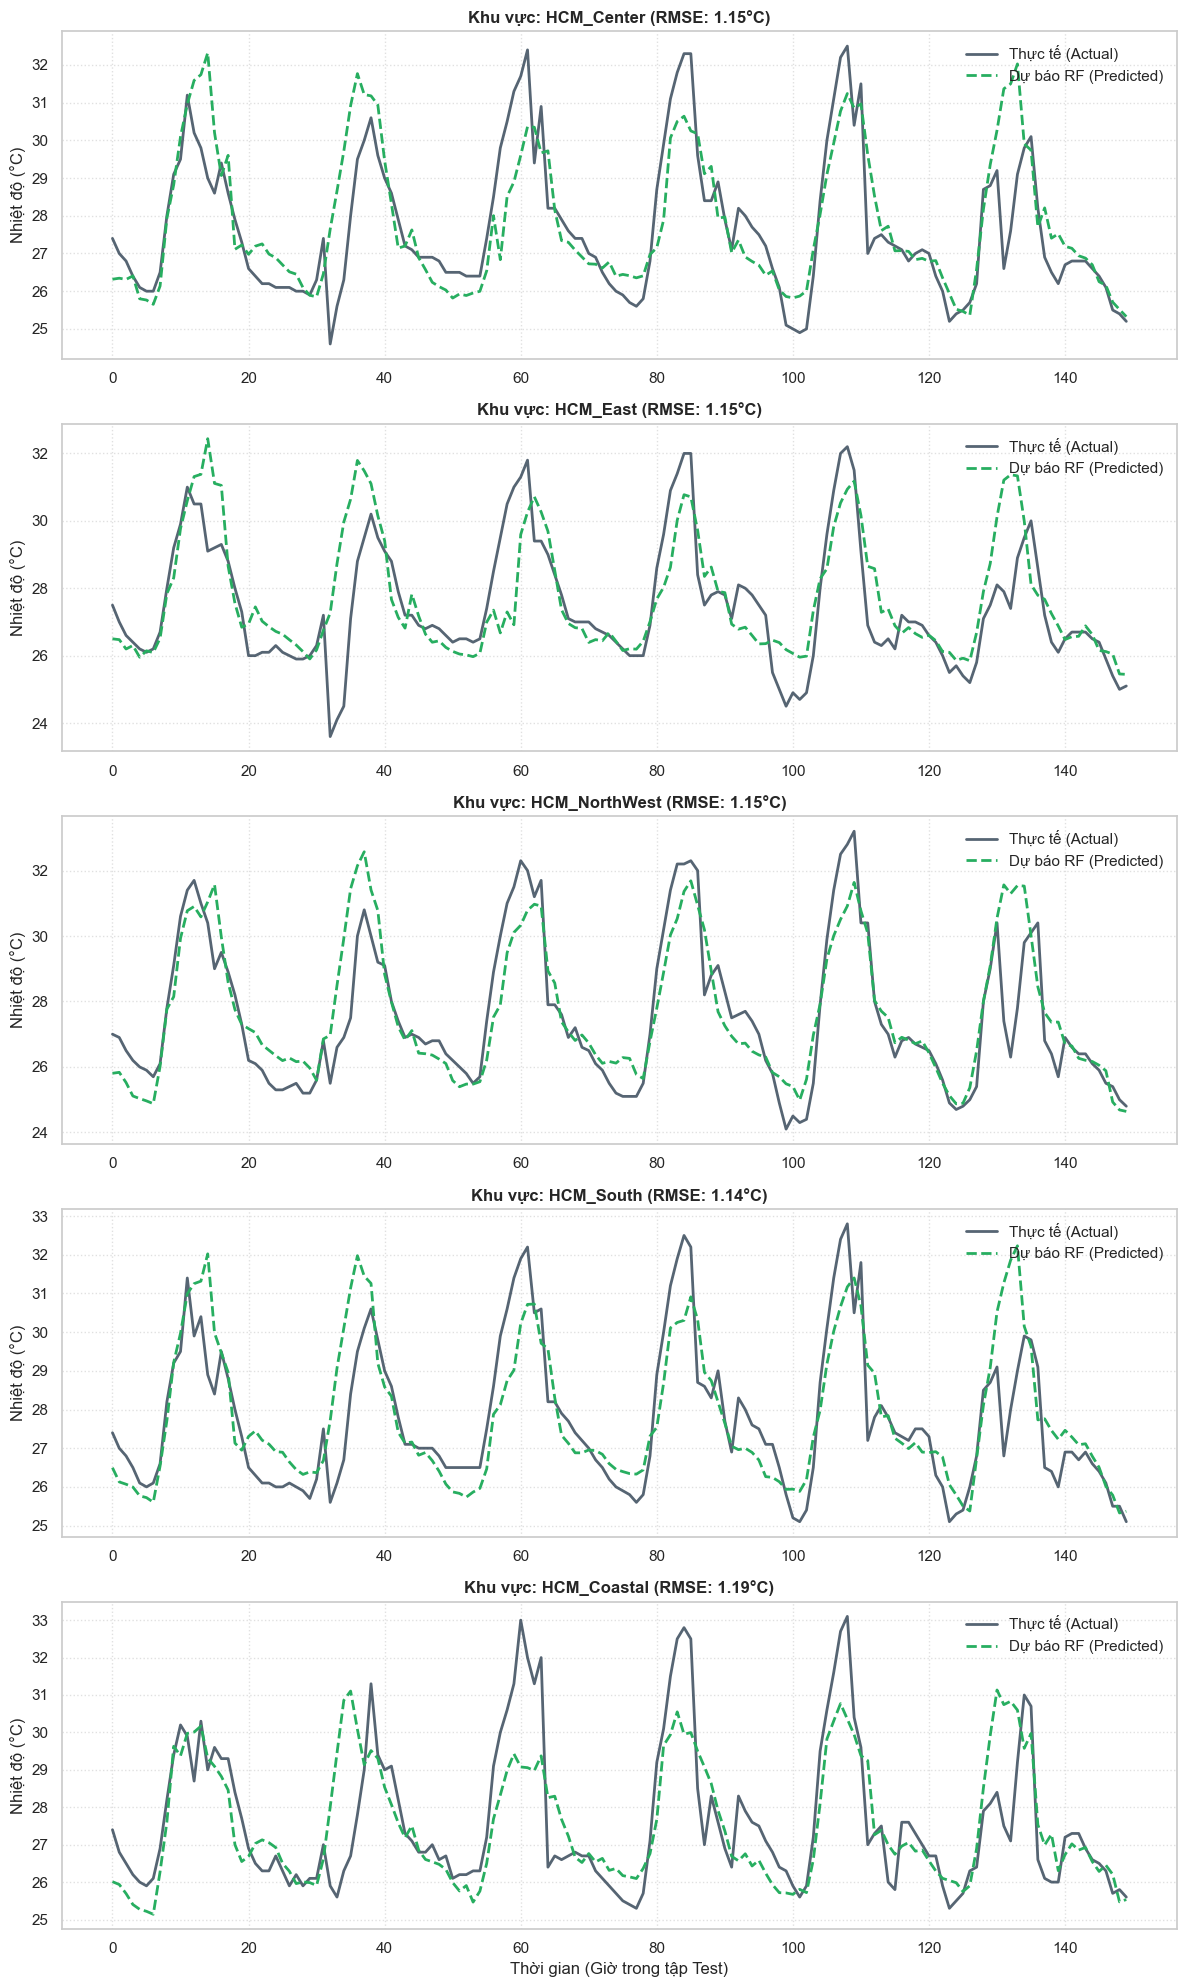

In [21]:
# Chỉ vẽ 150 giờ đầu tiên của tập Test để nhìn rõ
START_H, END_H = 0, 150

fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(12, 20))

for i, zone in enumerate(ZONES):
    ax = axes[i]
    
    # Lấy dữ liệu 24h đã lưu
    data = test_data[zone]
    y_true = data['y_test'].values[START_H:END_H]
    y_pred = data['preds'][START_H:END_H]
    rmse_val = data['rmse']
    
    # Vẽ đường
    ax.plot(y_true, label='Thực tế (Actual)', color='#2c3e50', 
            linewidth=2, alpha=0.8)
    ax.plot(y_pred, label='Dự báo RF (Predicted)', color='#27ae60', 
            linestyle='--', linewidth=2)
    
    # Trang trí
    ax.set_title(f'Khu vực: {zone} (RMSE: {rmse_val:.2f}°C)', 
                 fontsize=12, fontweight='bold')
    ax.set_ylabel('Nhiệt độ (°C)')
    ax.legend(loc='upper right')
    ax.grid(True, linestyle=':', alpha=0.6)
    
    if i == 4:
        ax.set_xlabel('Thời gian (Giờ trong tập Test)')

plt.tight_layout()
plt.show()

# FEATURE IMPORTANCE

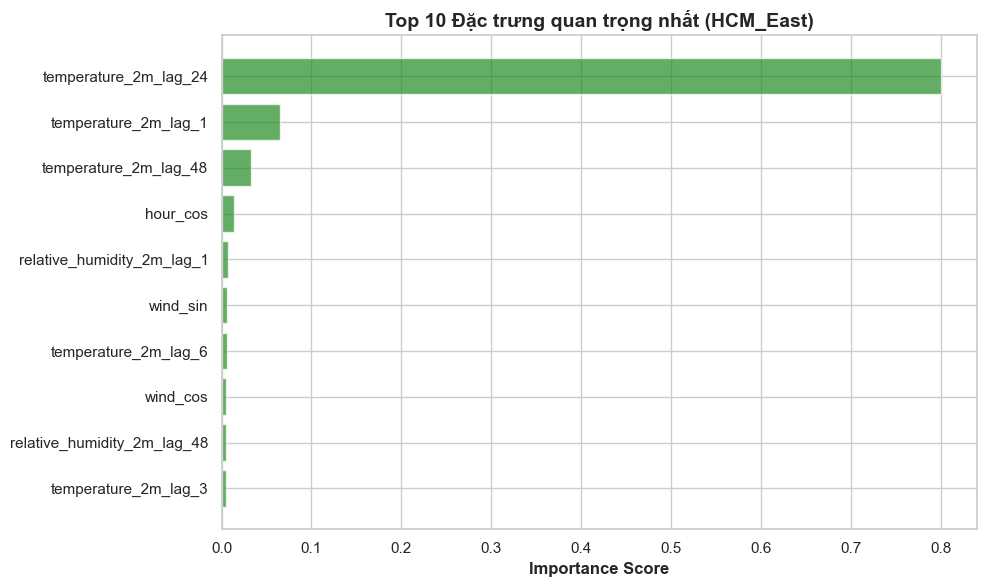

In [12]:
# Feature Importance (Lấy ví dụ vùng HCM_East)
model_east = models['HCM_East']

# Lấy importance
importances = model_east.feature_importances_
feature_names = X_train.columns
indices = np.argsort(importances)[::-1][:10]  # Top 10

plt.figure(figsize=(10, 6))
plt.barh(range(10), importances[indices], color='forestgreen', alpha=0.7)
plt.yticks(range(10), [feature_names[i] for i in indices])
plt.xlabel('Importance Score', fontweight='bold')
plt.title('Top 10 Đặc trưng quan trọng nhất (HCM_East)', 
          fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# RESIDUAL ANALYSIS

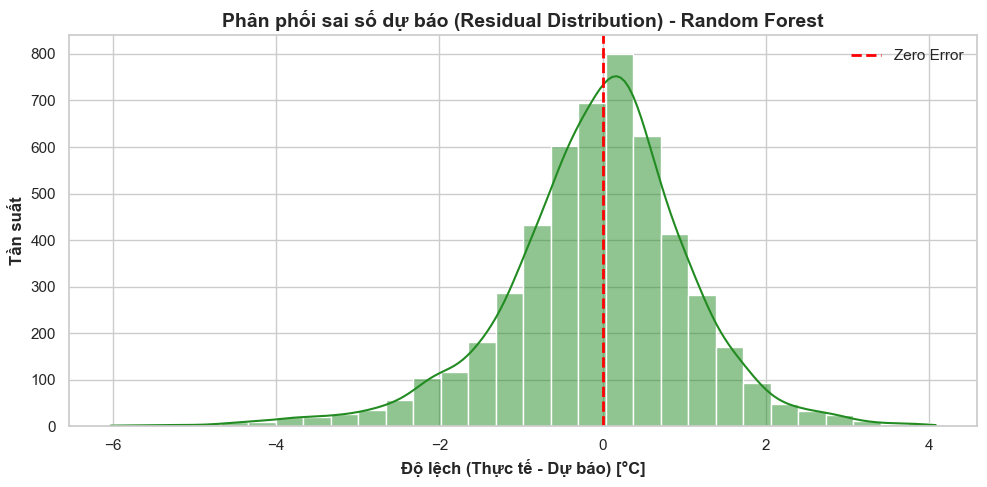


=== THỐNG KÊ SAI SỐ (HCM_East) ===
Trung bình: -0.0701°C (Gần 0 là tốt)
Độ lệch chuẩn: 1.1436°C
Min: -6.0285°C
Max: 4.0834°C


In [13]:
# Phân tích phân phối lỗi (Residuals)
residuals = test_data['HCM_East']['y_test'] - test_data['HCM_East']['preds']

plt.figure(figsize=(10, 5))
sns.histplot(residuals, kde=True, color='forestgreen', bins=30)
plt.axvline(0, color='red', linestyle='--', linewidth=2, label='Zero Error')
plt.title('Phân phối sai số dự báo (Residual Distribution) - Random Forest', 
          fontsize=14, fontweight='bold')
plt.xlabel('Độ lệch (Thực tế - Dự báo) [°C]', fontweight='bold')
plt.ylabel('Tần suất', fontweight='bold')
plt.legend()
plt.tight_layout()
plt.show()

# Thống kê residuals
print("\n" + "="*80)
print("=== THỐNG KÊ SAI SỐ (HCM_East) ===")
print("="*80)
print(f"Trung bình: {residuals.mean():.4f}°C (Gần 0 là tốt)")
print(f"Độ lệch chuẩn: {residuals.std():.4f}°C")
print(f"Min: {residuals.min():.4f}°C")
print(f"Max: {residuals.max():.4f}°C")

# ĐÁNH GIÁ KẾT QUẢ

In [23]:
print("\n" + "="*80)
print("=== ĐÁNH GIÁ KẾT QUẢ RANDOM FOREST VS ARIMA ===")
print("="*80)

# Lấy kết quả để so sánh
rf_avg = results_df[results_df['Model'] == 'Random Forest'][['RMSE', 'MAE', 'R2']].mean()
arima_results = results_df[results_df['Model'].str.contains('ARIMA')]
if len(arima_results) > 0:
    arima_avg = arima_results[['RMSE', 'MAE', 'R2']].mean()
else:
    arima_avg = None

print("""
Hiệu suất chung (Model Performance Overview)
------------------------------------------------""")
print(f"Random Forest:")
print(f"  - RMSE trung bình: {rf_avg['RMSE']:.4f}°C")
print(f"  - MAE trung bình: {rf_avg['MAE']:.4f}°C")
print(f"  - R² trung bình: {rf_avg['R2']:.4f}")

if arima_avg is not None:
    print(f"\nARIMA:")
    print(f"  - RMSE trung bình: {arima_avg['RMSE']:.4f}°C")
    print(f"  - MAE trung bình: {arima_avg['MAE']:.4f}°C")
    print(f"  - R² trung bình: {arima_avg['R2']:.4f}")
    
    improvement = ((arima_avg['RMSE'] - rf_avg['RMSE']) / arima_avg['RMSE'] * 100)
    print(f"\n→ Random Forest tốt hơn ARIMA: {improvement:.1f}%")


=== ĐÁNH GIÁ KẾT QUẢ RANDOM FOREST VS ARIMA ===

Hiệu suất chung (Model Performance Overview)
------------------------------------------------
Random Forest:
  - RMSE trung bình: 1.0717°C
  - MAE trung bình: 0.7704°C
  - R² trung bình: 0.7802
